In [5]:
## Tested using the following loaded modules
## module use /g/data/access/ngm/modules
## module load analysis3/21.10
import os, sys
workdir = "/g/data/xv83/users/bxn599/ACS/evaluation/"
os.chdir(workdir)
sys.path.append("./lib")
import glob
import xarray as xr
import numpy as np
import geopandas as gp
from datetime import datetime as dt
import lib_standards
import lib_spatial
import spatial_selection
import matplotlib as mpl
import matplotlib.pyplot as plt
import importlib
importlib.reload(lib_standards)
import warnings
warnings.filterwarnings('ignore')

font = {'size'   : 12}
mpl.rc('font', **font)

In [6]:
DATA_LOCATIONS = {
    'AGCD': "/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/indices/AUS-r005/none/BOM-AGCD/historical/none/none/none/climdex",
    'BARPA-R:ERA5': "/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/indices/AUS-15/BOM/ECMWF-ERA5/evaluation/none/BOM-BARPA-R/v1/climdex",
    'ERA5': "/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/indices/AUS-25/none/ECMWF-ERA5/historical/none/none/none/climdex",
    'CCAM:ERA5': "/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/indices/AUS-10/CSIRO/ECMWF-ERA5/evaluation/none/CSIRO-CCAM-2203/v1/climdex",
}
# Frequency of icclim indicator
FREQ = 'month'
# Data sources to consider here
SOURCES = ['BARPA-R:ERA5', 'CCAM:ERA5', 'AGCD', 'ERA5']
# Grid to used as the reference grid to compute difference metrics
REFERENCE_GRID = 'BARPA-R:ERA5'
# "Truth" for compute difference metrics
REFERENCE = 'AGCD'
# Region of interest, as per defined in lib_standards.DOMAINS
REGION = 'Australia'  
# Period of interest, as per defined in lib_standards.PERIODS
PERIOD = 'HISTORICAL_WHOLE' 
SEASON='all'

In [7]:
def prepare_data(index, sources=SOURCES, freq=FREQ, region=REGION, period=PERIOD, reference_grid=REFERENCE_GRID, season=SEASON):
    """
    Reads in the icclim data and regrid to the reference grid.
    """
    # Load the data sources
    ds = {}
    for s in sources:
        print("Reading the data {:}".format(s))
        fs = glob.glob(os.path.join(DATA_LOCATIONS[s], index, "{index}_*_{freq}_*.nc".format(index=index, freq=freq)))
        ds[s] = xr.open_dataset(fs[0])
        ds[s] = lib_standards.standardise_data(ds[s], region=region, period=period, season=season, compute=True)

    # Regrid to the REFERENCE_GRID
    ds_regrid = {}
    for s in sources:
        print("Regridding the data {:} to reference grid of {:}".format(s, reference_grid))
        #ds_regrid[s] = lib_spatial.add_region_land_mask(ds[s], region)
        ds_regrid[s] = ds[s]
        if s == reference_grid:
            ds_regrid[s] = ds_regrid[s].compute()
        else:
            ds_regrid[s] = lib_standards.regrid(ds_regrid[s], ds[reference_grid]).compute()
    return ds_regrid

# For the main paper

index = TX
Reading the data BARPA-R:ERA5
Reading the data CCAM:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data CCAM:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5
index = TX:DJF
Reading the data BARPA-R:ERA5
Reading the data CCAM:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data CCAM:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5
index = TX:JJA
Reading the data BARPA-R:ERA5
Reading the data CCAM:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data CCAM:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to

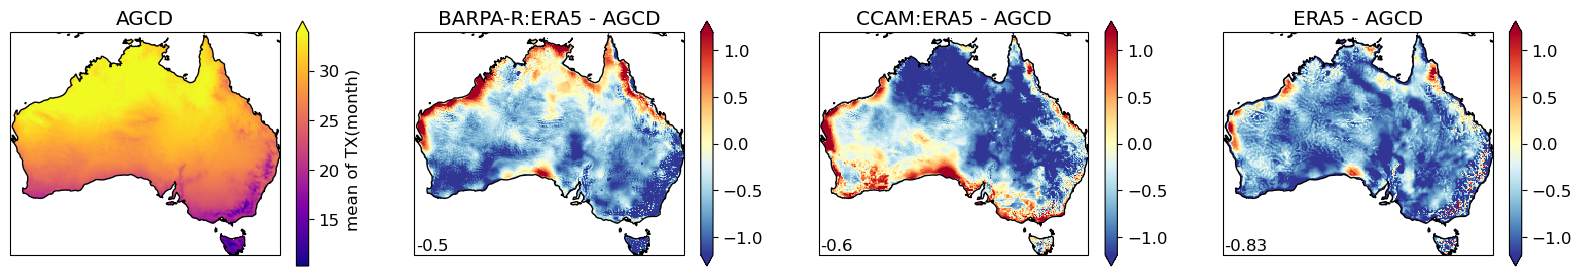

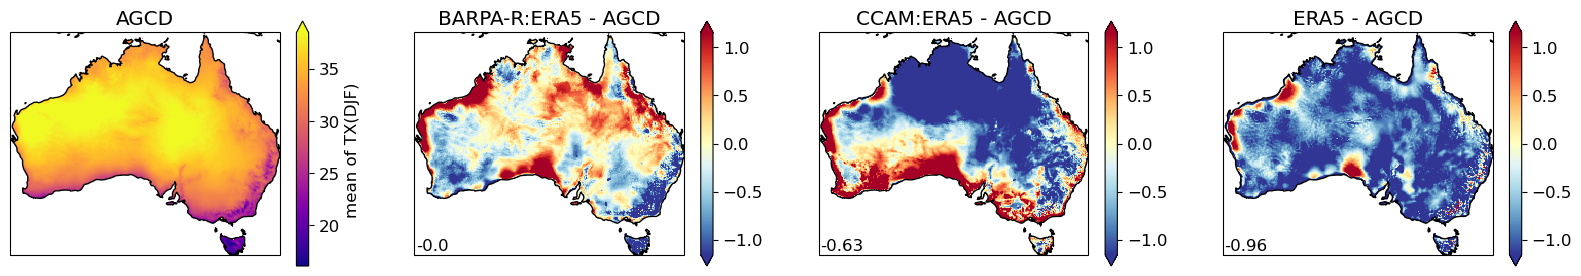

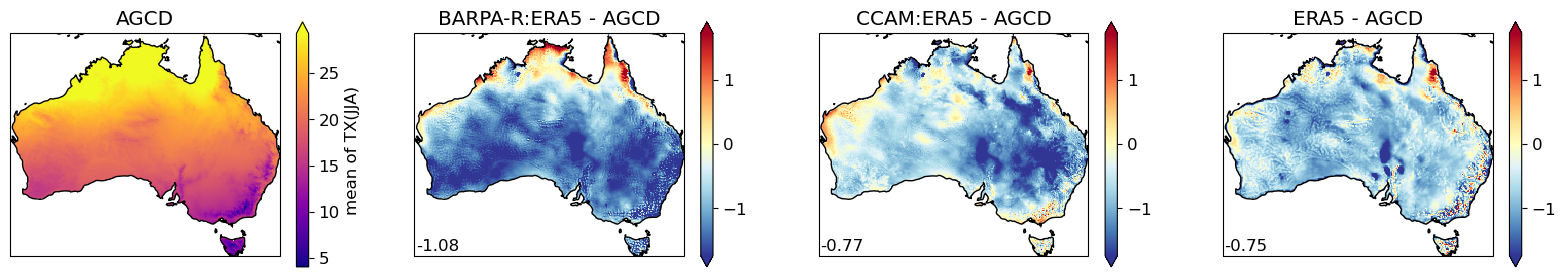

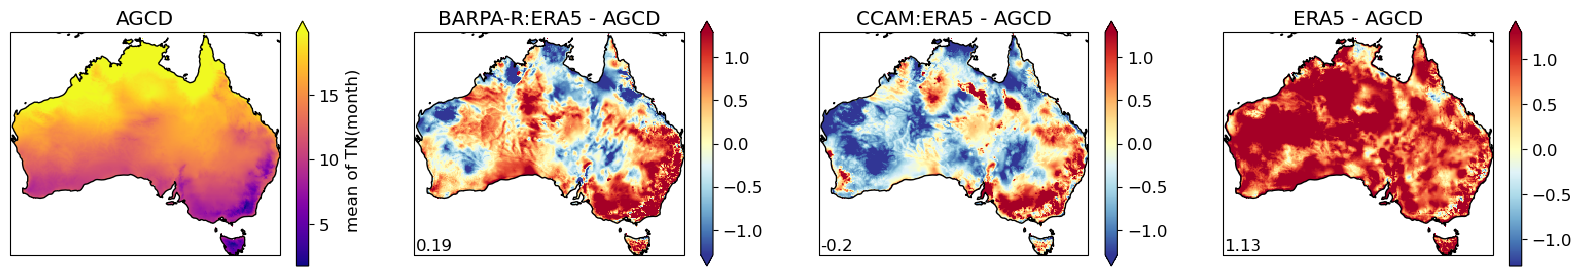

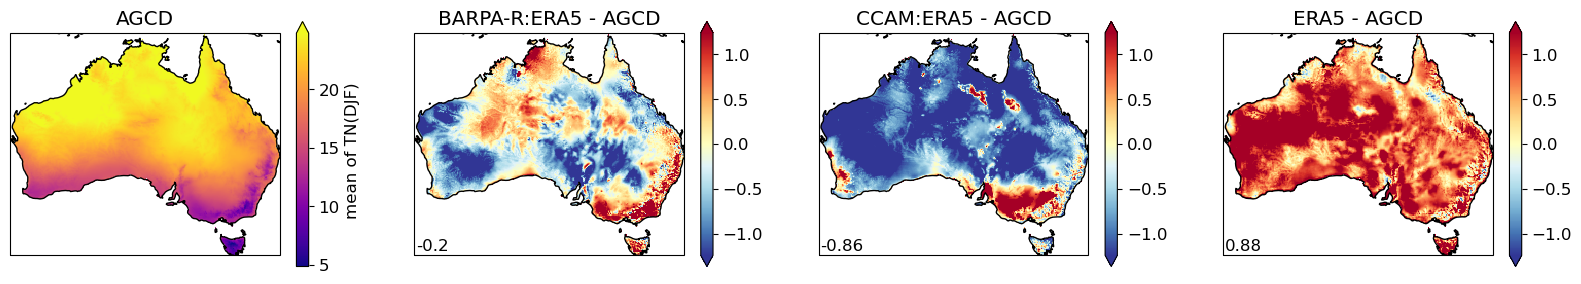

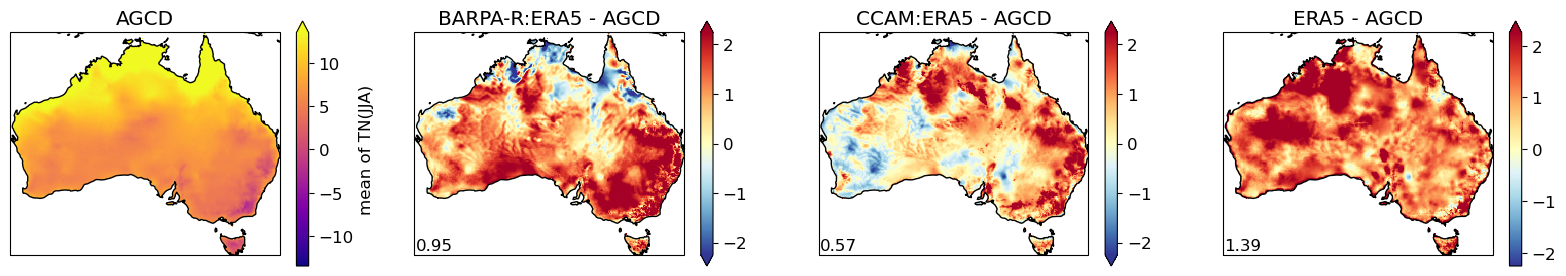

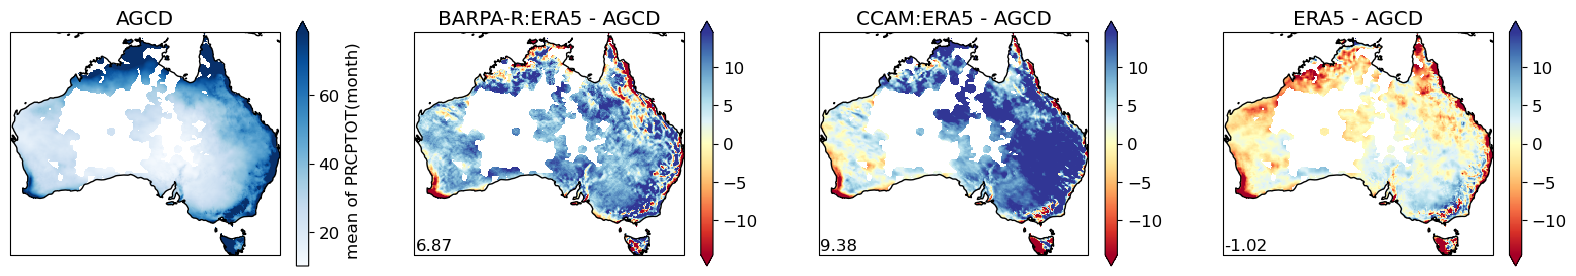

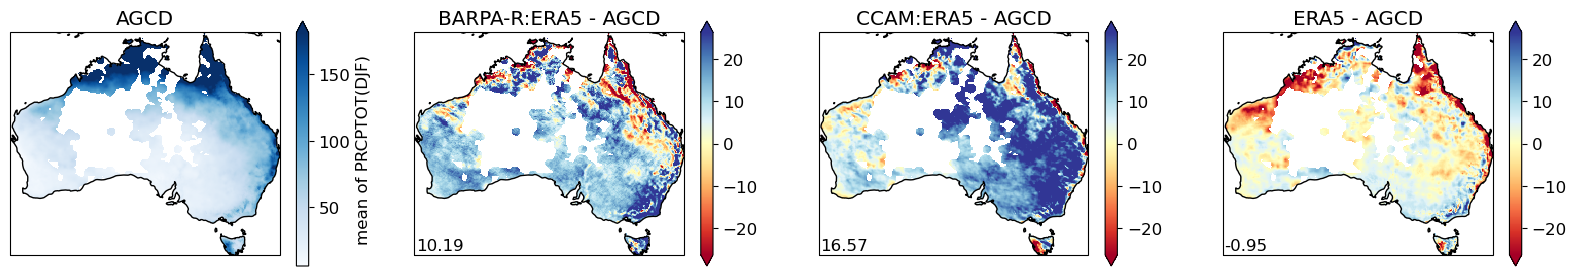

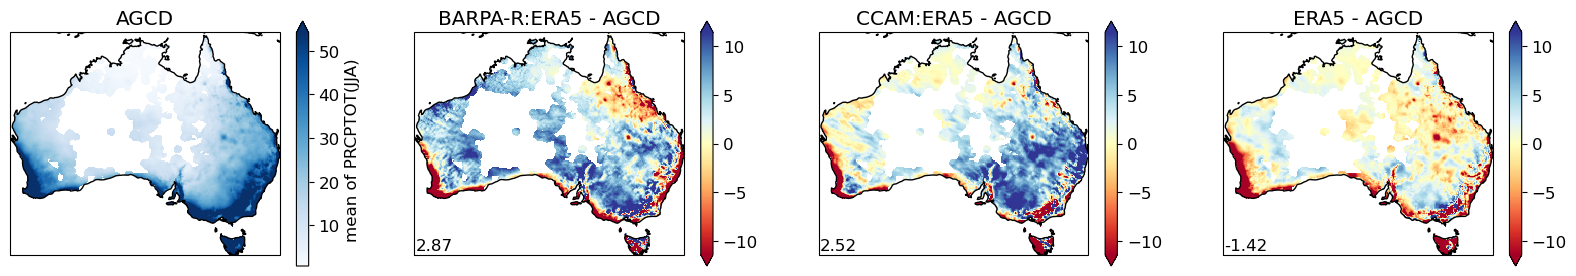

In [9]:
INDEXES = ['TX', 'TX:DJF', 'TX:JJA', 'TN', 'TN:DJF', 'TN:JJA', 'PRCPTOT', 'PRCPTOT:DJF', 'PRCPTOT:JJA']
#INDEXES = ['TX:DJF', 'TX:JJA', 'TN:DJF', 'TN:JJA', 'PRCPTOT:DJF', 'PRCPTOT:JJA']
#INDEXES = ['PRCPTOT:DJF', 'PRCPTOT:JJA']
#INDEXES = ['TX:DJF', 'TN:DJF', 'PRCPTOT:DJF']
for index in INDEXES:
    print("index = {:}".format(index))
    
    # check whether the index has special conditions
    index_condition = None
    if not ":" in index:
        # Prepare all the icclim data as per the setup in CONFIGURATIONS
        ds = prepare_data(index)
        clabel = "mean of {index}({freq})".format(index=index, freq=FREQ)
    else:
        index_condition = index.split(":")[1]
        index = index.split(":")[0]
        ds = prepare_data(index, season=index_condition)
        clabel = "mean of {index}({index_condition})".format(index=index, index_condition=index_condition)
    
    ds_target = {}
    for s in SOURCES:
        ds_target[s] = ds[s][index].mean(dim='time')
        ds_target[s] = lib_spatial.apply_region_mask(ds_target[s], 'Australia')
        if 'PRCPTOT' in index:
            ds_target[s] = lib_spatial.apply_agcd_data_mask(ds_target[s])

                
    if index in ['TX', 'TN']:
        cmap_variable = 'temp'
        cmap_class = 'hot'
    if index in ["PRCPTOT"]:
        cmap_variable = 'precip'
        cmap_class = 'wet'
    
    lib_standards.spatial_plot(ds_target, reference=REFERENCE, 
                               cmap_variable=cmap_variable, cmap_class=cmap_class, 
                               clabel=clabel, plot_difference=True,
                               include_all_data=False, include_diff_avg=True)

# For Supplementary Material

index = TX:MAM
Reading the data BARPA-R:ERA5
Reading the data CCAM:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data CCAM:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5
index = TX:SON
Reading the data BARPA-R:ERA5
Reading the data CCAM:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data CCAM:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5
index = TN:MAM
Reading the data BARPA-R:ERA5
Reading the data CCAM:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data CCAM:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGC

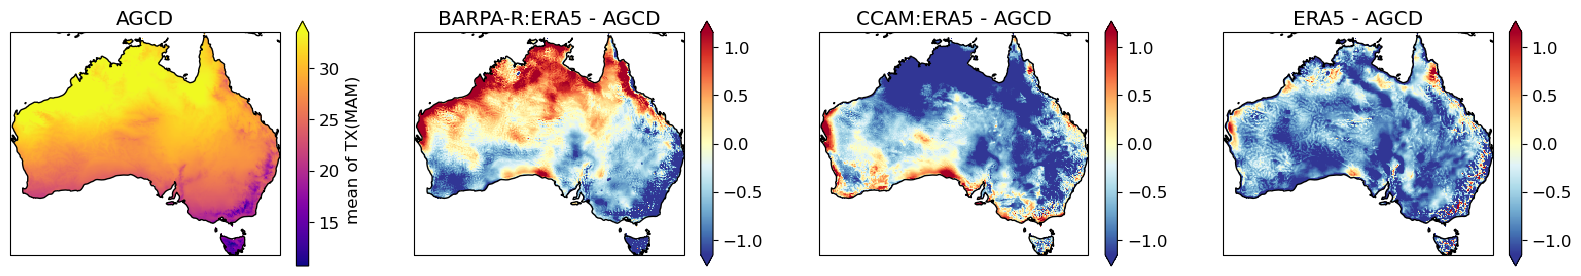

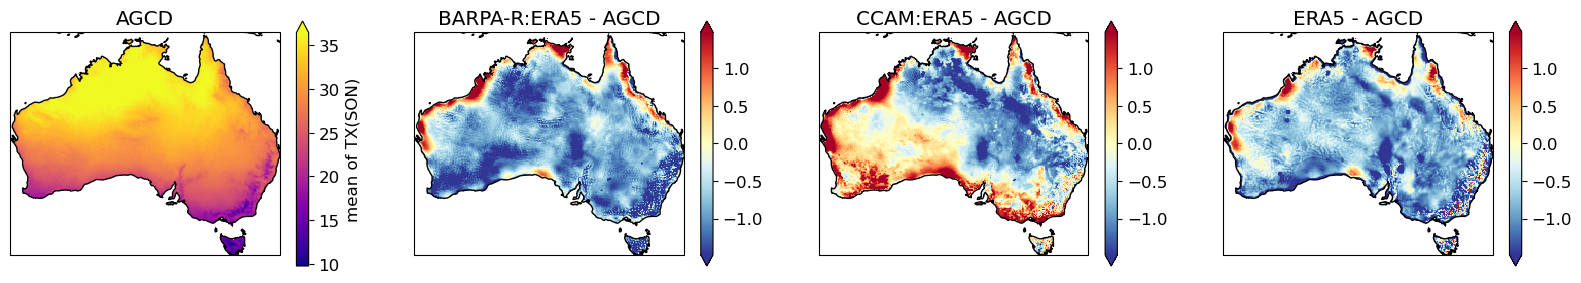

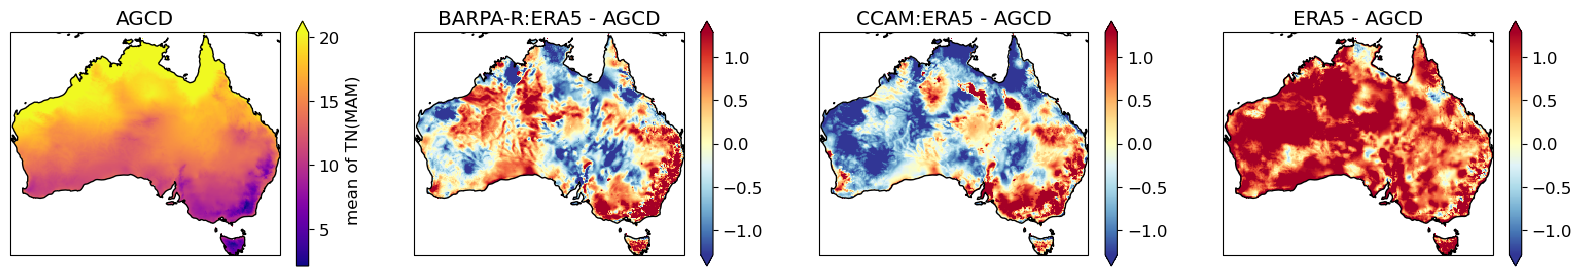

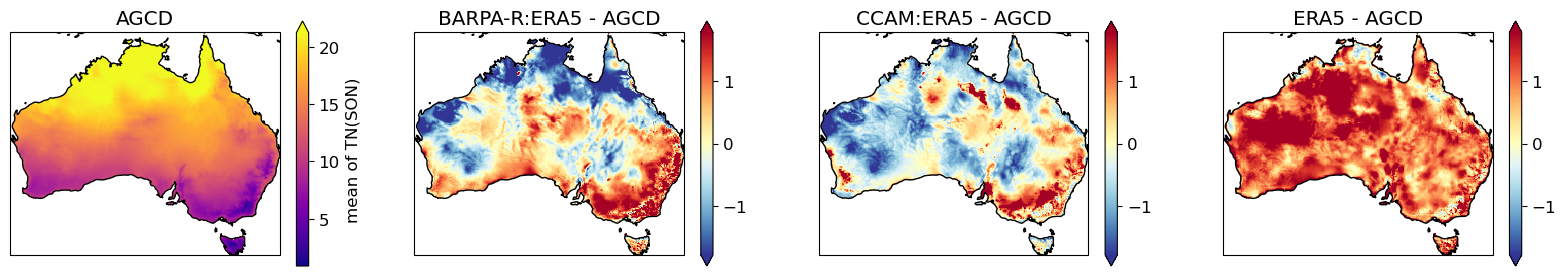

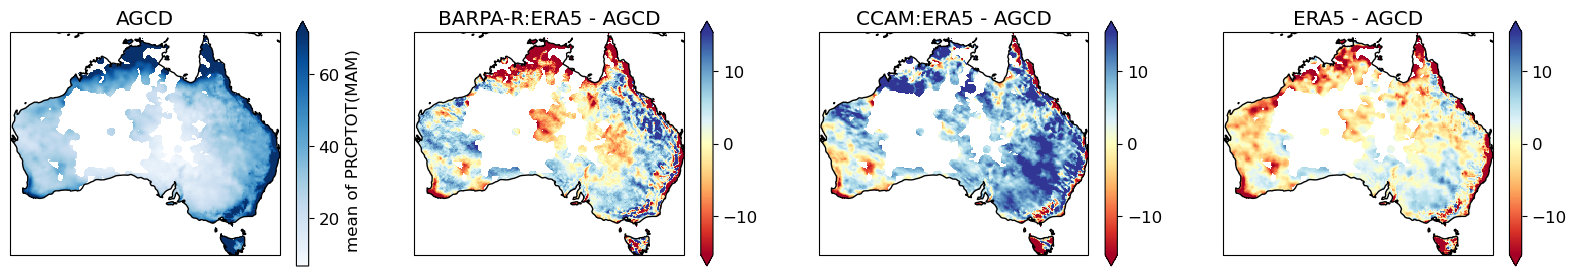

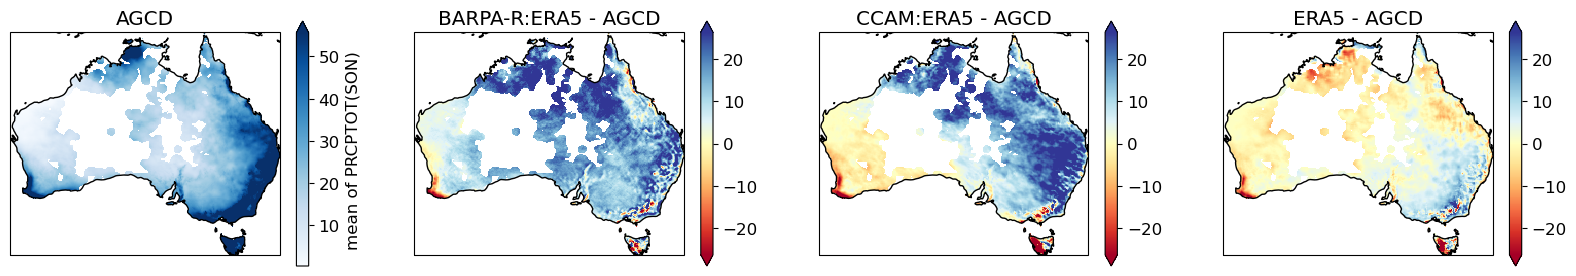

In [10]:
importlib.reload(lib_standards)
INDEXES = ['TX:MAM', 'TX:SON', 'TN:MAM', 'TN:SON', 'PRCPTOT:MAM', 'PRCPTOT:SON']
for index in INDEXES:
    print("index = {:}".format(index))
    
    # check whether the index has special conditions
    index_condition = None
    if not ":" in index:
        # Prepare all the icclim data as per the setup in CONFIGURATIONS
        ds = prepare_data(index)
        clabel = "mean of {index}({freq})".format(index=index, freq=FREQ)
    else:
        index_condition = index.split(":")[1]
        index = index.split(":")[0]
        ds = prepare_data(index, season=index_condition)
        clabel = "mean of {index}({index_condition})".format(index=index, index_condition=index_condition)
    
    ds_target = {}
    for s in SOURCES:
        ds_target[s] = ds[s][index].mean(dim='time')
        ds_target[s] = lib_spatial.apply_region_mask(ds_target[s], 'Australia')
        if 'PRCPTOT' in index:
            ds_target[s] = lib_spatial.apply_agcd_data_mask(ds_target[s])
                
    if index in ['TX', 'TN']:
        cmap_variable = 'temp'
        cmap_class = 'hot'
    if index in ["PRCPTOT"]:
        cmap_variable = 'precip'
        cmap_class = 'wet'
    
    lib_standards.spatial_plot(ds_target, reference=REFERENCE, 
                               cmap_variable=cmap_variable, cmap_class=cmap_class, 
                               clabel=clabel, plot_difference=True,
                               include_all_data=False, include_diff_avg=False)

index = TX:DJF
Reading the data BARPA-R:ERA5
Reading the data CCAM:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data CCAM:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5
index = TX:JJA
Reading the data BARPA-R:ERA5
Reading the data CCAM:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data CCAM:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGCD to reference grid of BARPA-R:ERA5
Regridding the data ERA5 to reference grid of BARPA-R:ERA5
index = TN:DJF
Reading the data BARPA-R:ERA5
Reading the data CCAM:ERA5
Reading the data AGCD
Reading the data ERA5
Regridding the data BARPA-R:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data CCAM:ERA5 to reference grid of BARPA-R:ERA5
Regridding the data AGC

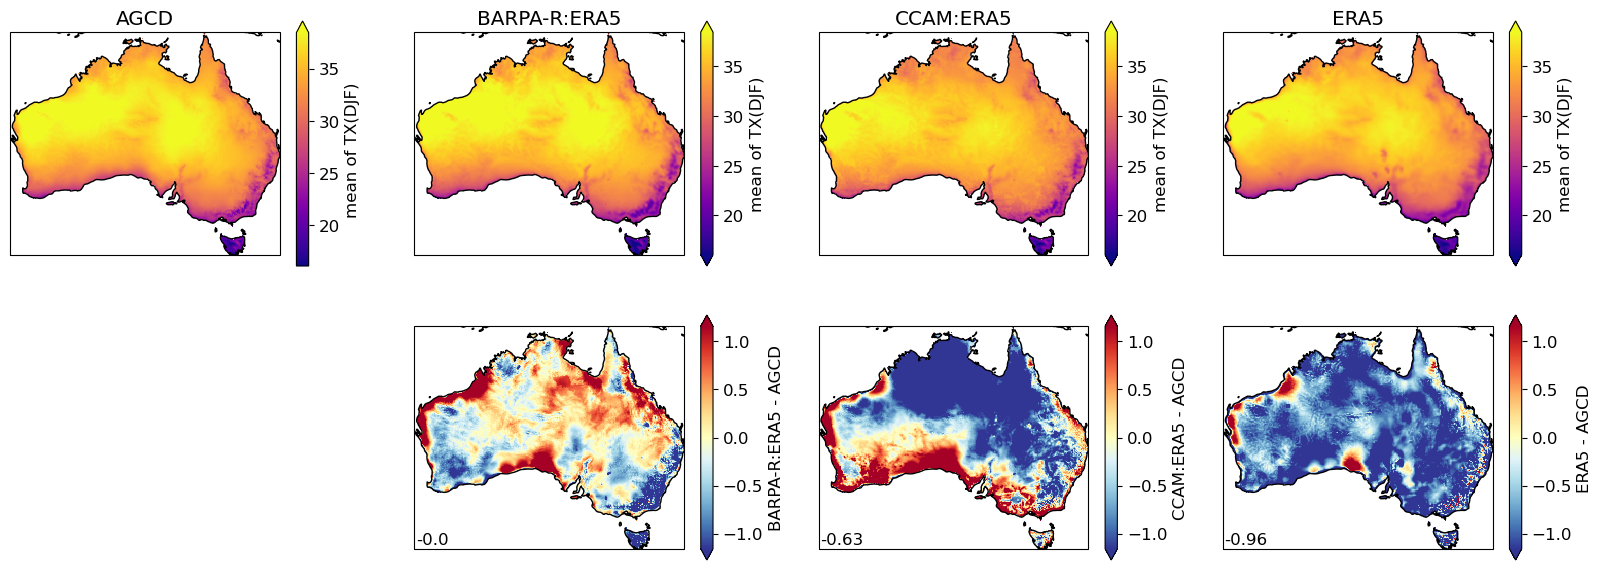

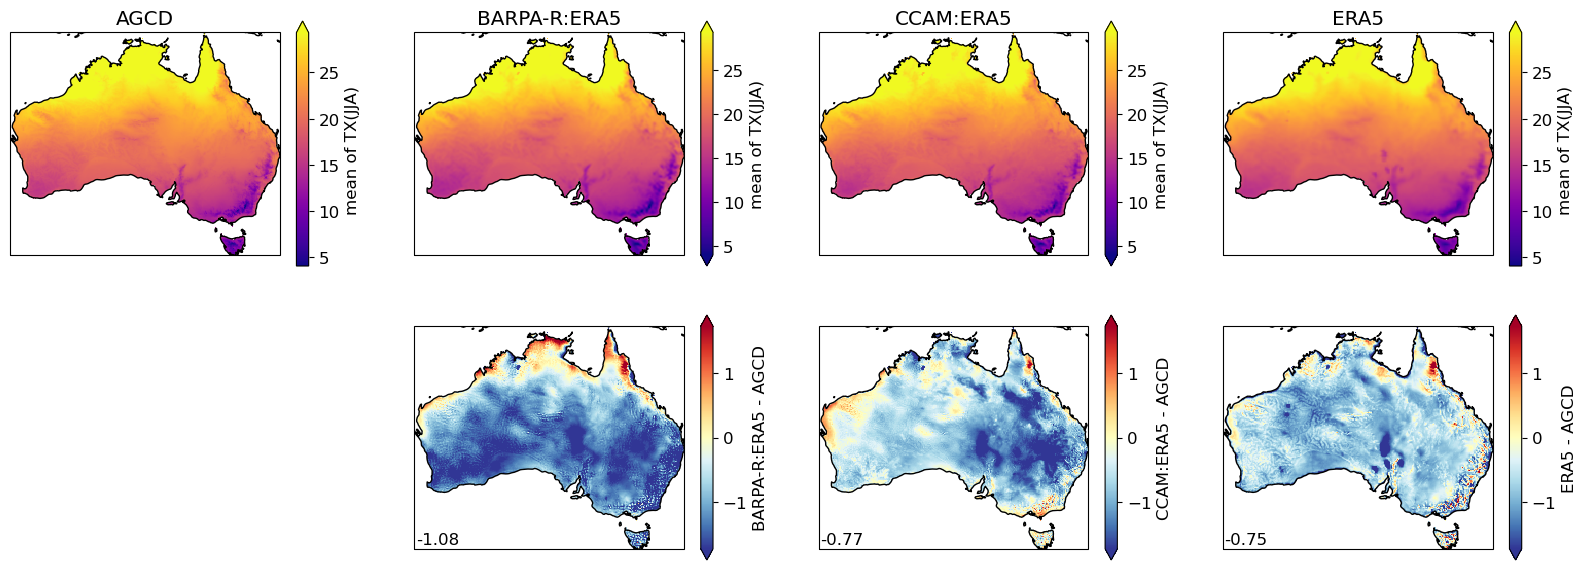

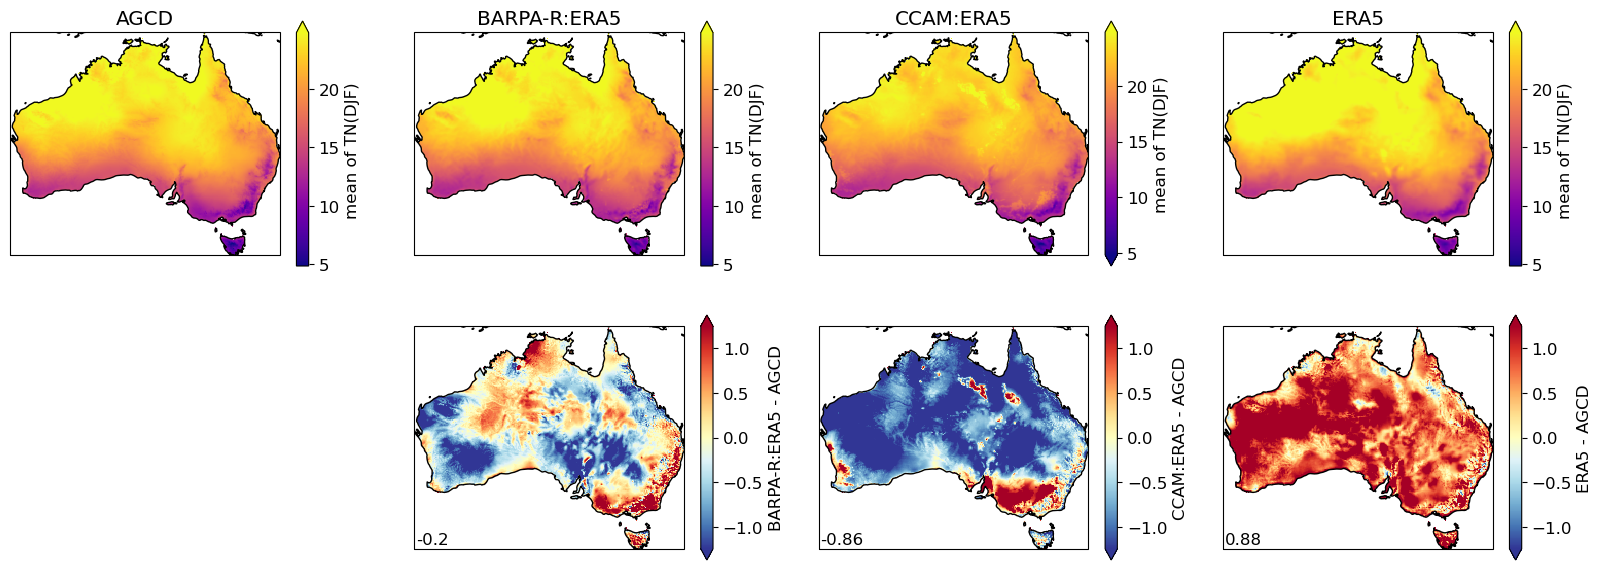

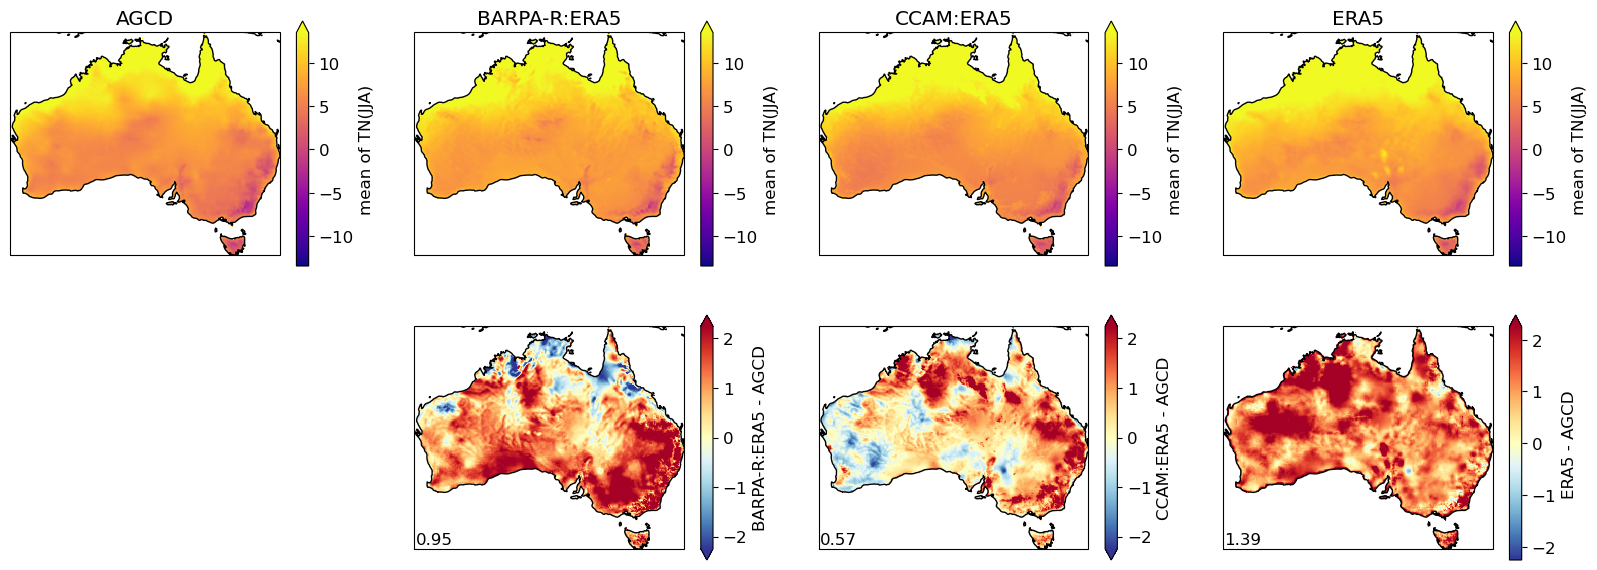

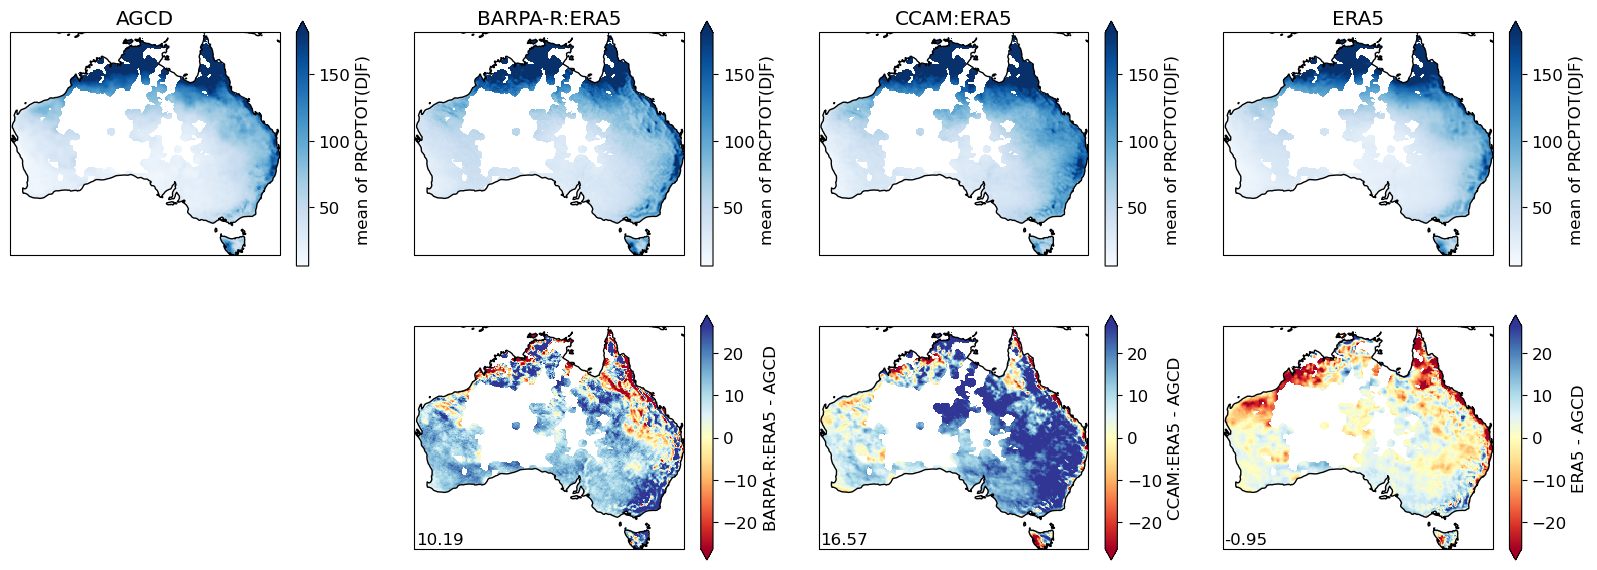

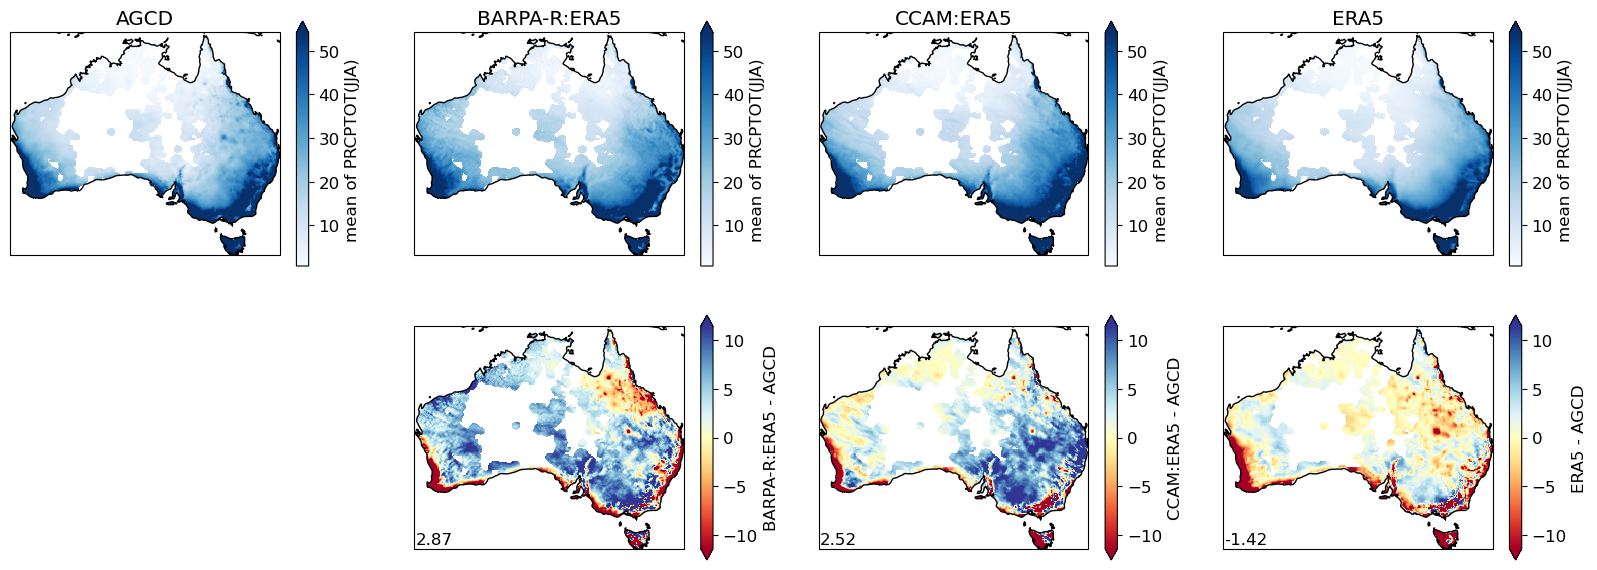

In [11]:
#INDEXES = ['TX', 'TX:DJF', 'TX:JJA', 'TN', 'TN:DJF', 'TN:JJA', 'PRCPTOT', 'PRCPTOT:DJF', 'PRCPTOT:JJA']
INDEXES = ['TX:DJF', 'TX:JJA', 'TN:DJF', 'TN:JJA', 'PRCPTOT:DJF', 'PRCPTOT:JJA']
for index in INDEXES:
    print("index = {:}".format(index))
    
    # check whether the index has special conditions
    index_condition = None
    if not ":" in index:
        # Prepare all the icclim data as per the setup in CONFIGURATIONS
        ds = prepare_data(index)
        clabel = "mean of {index}({freq})".format(index=index, freq=FREQ)
    else:
        index_condition = index.split(":")[1]
        index = index.split(":")[0]
        ds = prepare_data(index, season=index_condition)
        clabel = "mean of {index}({index_condition})".format(index=index, index_condition=index_condition)
    
    ds_target = {}
    for s in SOURCES:
        ds_target[s] = ds[s][index].mean(dim='time')
        ds_target[s] = lib_spatial.apply_region_mask(ds_target[s], 'Australia')
        if 'PRCPTOT' in index:
            ds_target[s] = lib_spatial.apply_agcd_data_mask(ds_target[s])
                
    if index in ['TX', 'TN']:
        cmap_variable = 'temp'
        cmap_class = 'hot'
    if index in ["PRCPTOT"]:
        cmap_variable = 'precip'
        cmap_class = 'wet'
    
    lib_standards.spatial_plot(ds_target, reference=REFERENCE, 
                               cmap_variable=cmap_variable, cmap_class=cmap_class, 
                               clabel=clabel, plot_difference=True,
                               include_all_data=True)